In [1]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib.pyplot as plt
from original import NonStationaryGP
#from hyperposterior import NonStationaryGP
import pandas as pd

# plot settings
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

1459.3277316758752


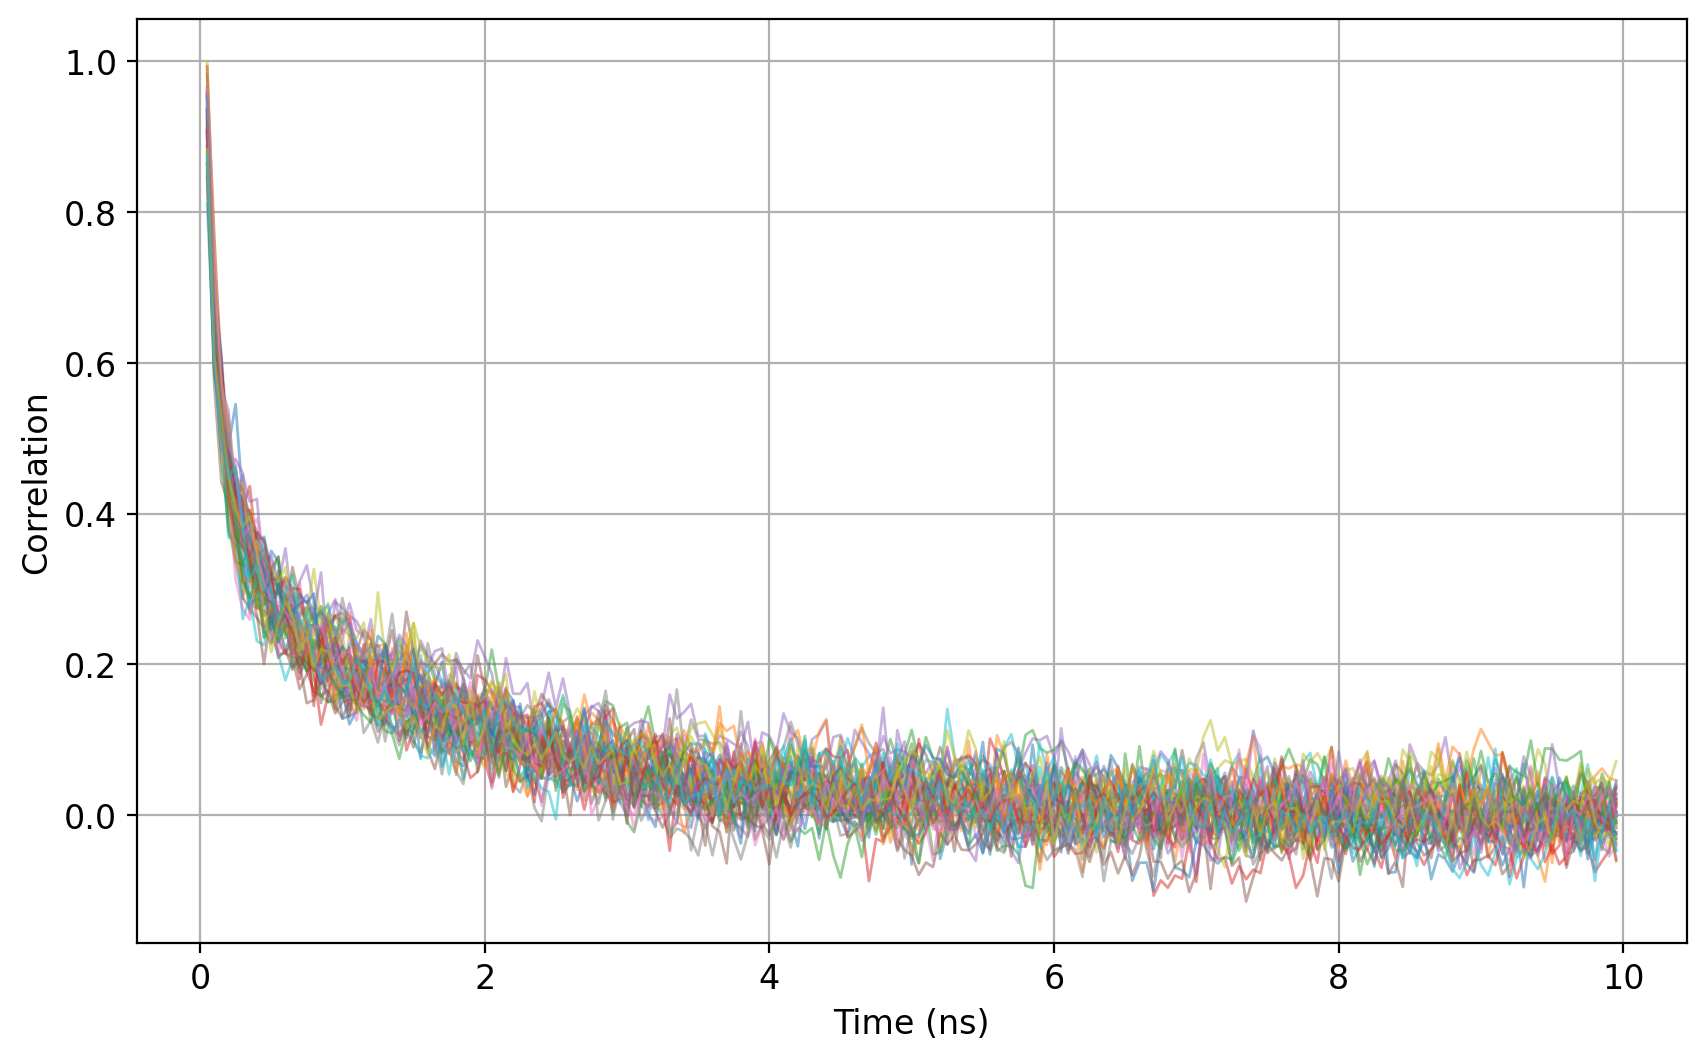

In [2]:
n_replicas = 50
dt = 500e-15*1e9  # nanoseconds, makes numbers bigger
n_datasteps = 2000001
time = np.arange(0, n_datasteps) * dt  # full time vector

# Subsample factor to reduce training points
subsample = 100 #take every 200th sampled point to improve numerical stability
time_sub = time[::subsample]

# Trim the longer time data that is just noise
half_idx = len(time_sub) // 100
time_sub = time_sub[:half_idx]

# Load 50 replicas of J_corr_z, subsample + cut last half
Y_list = []
for i in range(n_replicas):
    corr_fn = np.load(f"J_z/replica_{i+1:02d}/J_corr/J_corr_z.npy")
    corr_sub = corr_fn[::subsample][:half_idx]
    Y_list.append(corr_sub)

#convert into torch for GP computation
Y_full = np.stack(Y_list)  # shape (n_replicas, T)
time_sub = time_sub[1:]
Y_full = Y_full[:, 1:]
scale = np.max(np.abs(Y_full))  # single scalar across all replicas
print(scale)
Y_full_norm = Y_full / scale
Y = torch.tensor(Y_full_norm, dtype=torch.float64)
time_grid = torch.tensor(time_sub, dtype=torch.float64).unsqueeze(-1)

plt.figure(figsize=(10,6))
for i in range(n_replicas):
    plt.plot(time_grid.squeeze().numpy(), Y[i].numpy(), alpha=0.5, lw=1)
plt.xlabel("Time (ns)")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

In [3]:
import os

# Initialize GP
gp_model = NonStationaryGP()

# File path for saving/loading parameters
params_path = "gp_params.pth"

# Try to load saved parameters
try:
    gp_model.load_state_dict(torch.load(params_path))
    print(f"Loaded saved parameters from {params_path}")
except FileNotFoundError:
    print(f"No saved parameters found at {params_path}. Proceeding with training.")
    # Optimizer
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=1e-3)
    epochs = 5000
    losses = []

    # Training loop with debugging
    for step in range(epochs):
        optimizer.zero_grad()
        loss = sum(gp_model.NEG_LMLH(time_grid, Y[i]) for i in range(n_replicas))
        losses.append(loss.item())
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Step {step}: Loss is NaN or Inf! Breaking.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(gp_model.parameters(), max_norm=10.0)  # safety
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    # Save trained parameters
    torch.save(gp_model.state_dict(), params_path)
    print(f"Saved trained parameters to {params_path}")
except Exception as e:
    print(f"Error loading parameters from {params_path}: {e}. Proceeding with training.")
    # Optimizer
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=1e-3)
    epochs = 5000
    losses = []

    # Training loop with debugging
    for step in range(epochs):
        optimizer.zero_grad()
        loss = sum(gp_model.NEG_LMLH(time_grid, Y[i]) for i in range(n_replicas))
        losses.append(loss.item())
        
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Step {step}: Loss is NaN or Inf! Breaking.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(gp_model.parameters(), max_norm=10.0)  # safety
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")

    # Save trained parameters
    torch.save(gp_model.state_dict(), params_path)
    print(f"Saved trained parameters to {params_path}")

# Print final parameters
fitted_params = gp_model.print_params()

Loaded saved parameters from gp_params.pth
Optimized parameters:
  ell      = 33.7076
  max_val  = 6.0320
  slope    = 1.6961
  loc      = 0.0236
  sigma_n  = 0.036751
  A        = 3.9486
  tau      = 0.8095


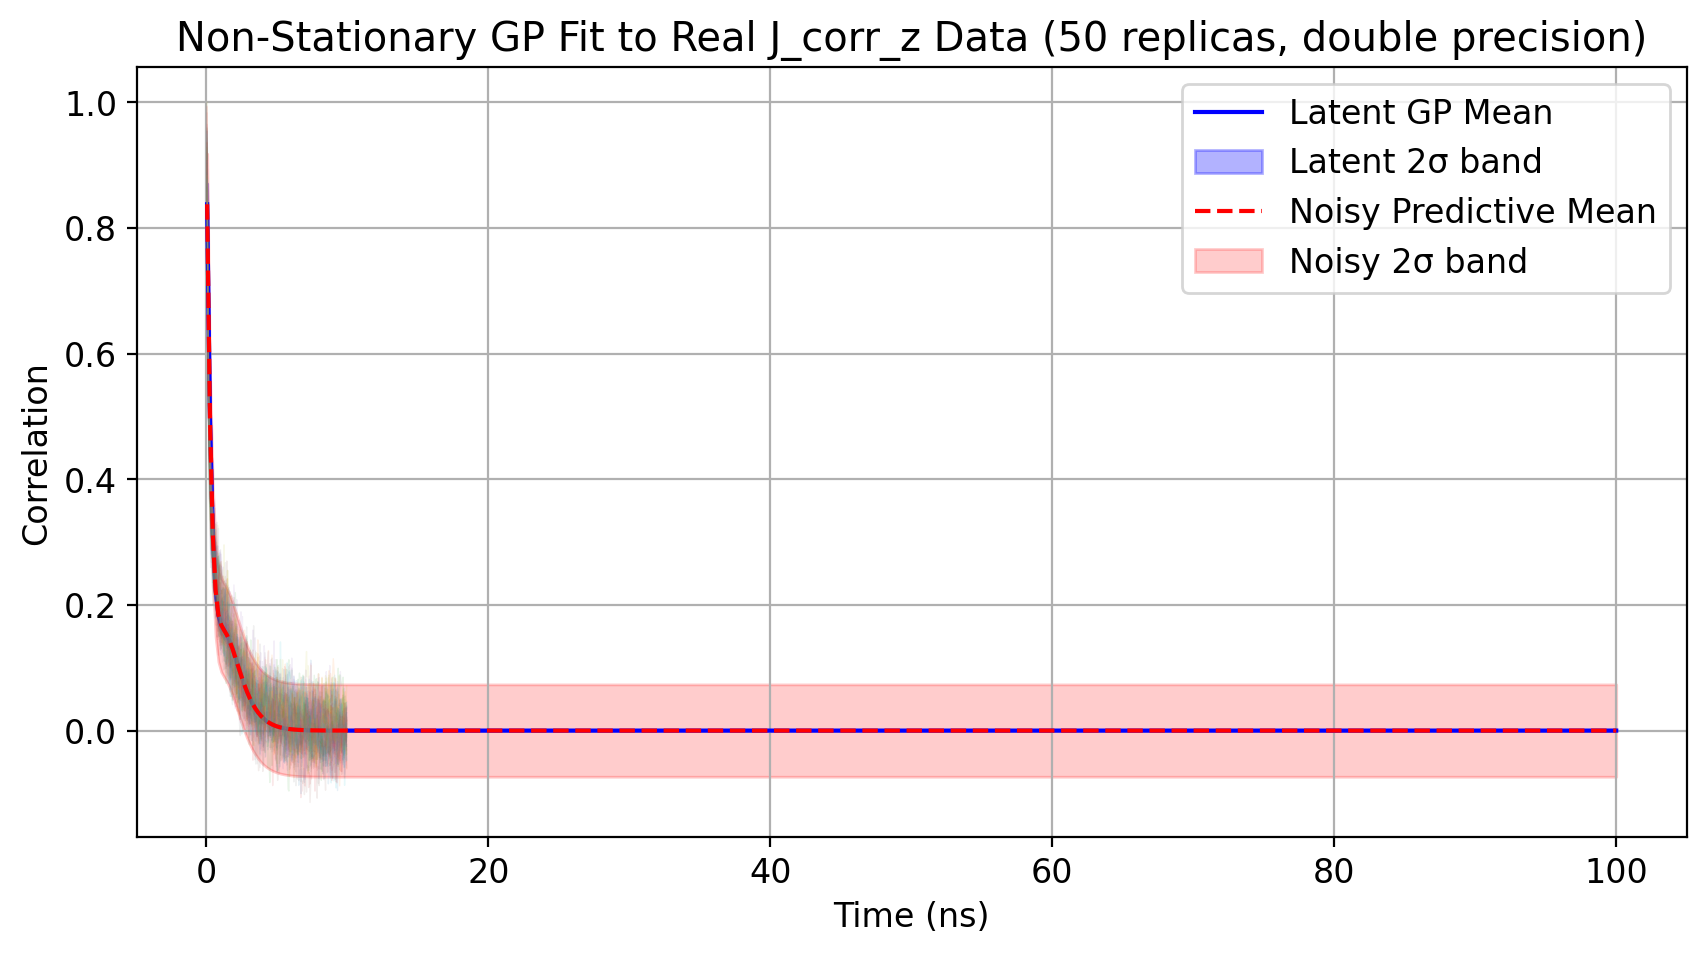

In [4]:
# Extend test grid if desired (double precision)
X_test = torch.linspace(time_sub[0], 100, 500, dtype=torch.float64).unsqueeze(-1)
mu_post, cov_post = gp_model.predict(time_grid, Y[0], X_test)
std_post = torch.sqrt(torch.diag(cov_post))
sigma_n = gp_model.sigma_n
std_post_with_noise = torch.sqrt(std_post**2 + sigma_n**2)

plt.figure(figsize=(10,5))
# Plot all replicas
# for i in range(n_replicas):
#     plt.plot(time_grid.squeeze().numpy(), Y[i].numpy(), color='gray', alpha=0.5)
# Latent GP posterior (noiseless)
plt.plot(X_test.squeeze().detach().numpy(), mu_post.detach().numpy(), 'b', label="Latent GP Mean")
plt.fill_between(
    X_test.squeeze().detach().numpy(),
    (mu_post - 2*std_post).detach().numpy(),
    (mu_post + 2*std_post).detach().numpy(),
    color='b', alpha=0.3, label="Latent 2σ band"
)
# Posterior predictive including observational noise
for i in range(n_replicas):
    plt.plot(time_grid.squeeze().numpy(), Y[i].numpy(), alpha=0.1, lw=0.5)
plt.plot(X_test.squeeze().detach().numpy(), mu_post.detach().numpy(), 'r--', label="Noisy Predictive Mean")
plt.fill_between(
    X_test.squeeze().detach().numpy(),
    (mu_post - 2*std_post_with_noise).detach().numpy(),
    (mu_post + 2*std_post_with_noise).detach().numpy(),
    color='r', alpha=0.2, label="Noisy 2σ band"
)
plt.xlabel("Time (ns)")
plt.ylabel("Correlation")
plt.title("Non-Stationary GP Fit to Real J_corr_z Data (50 replicas, double precision)")
plt.legend()
plt.grid(True)
plt.show()

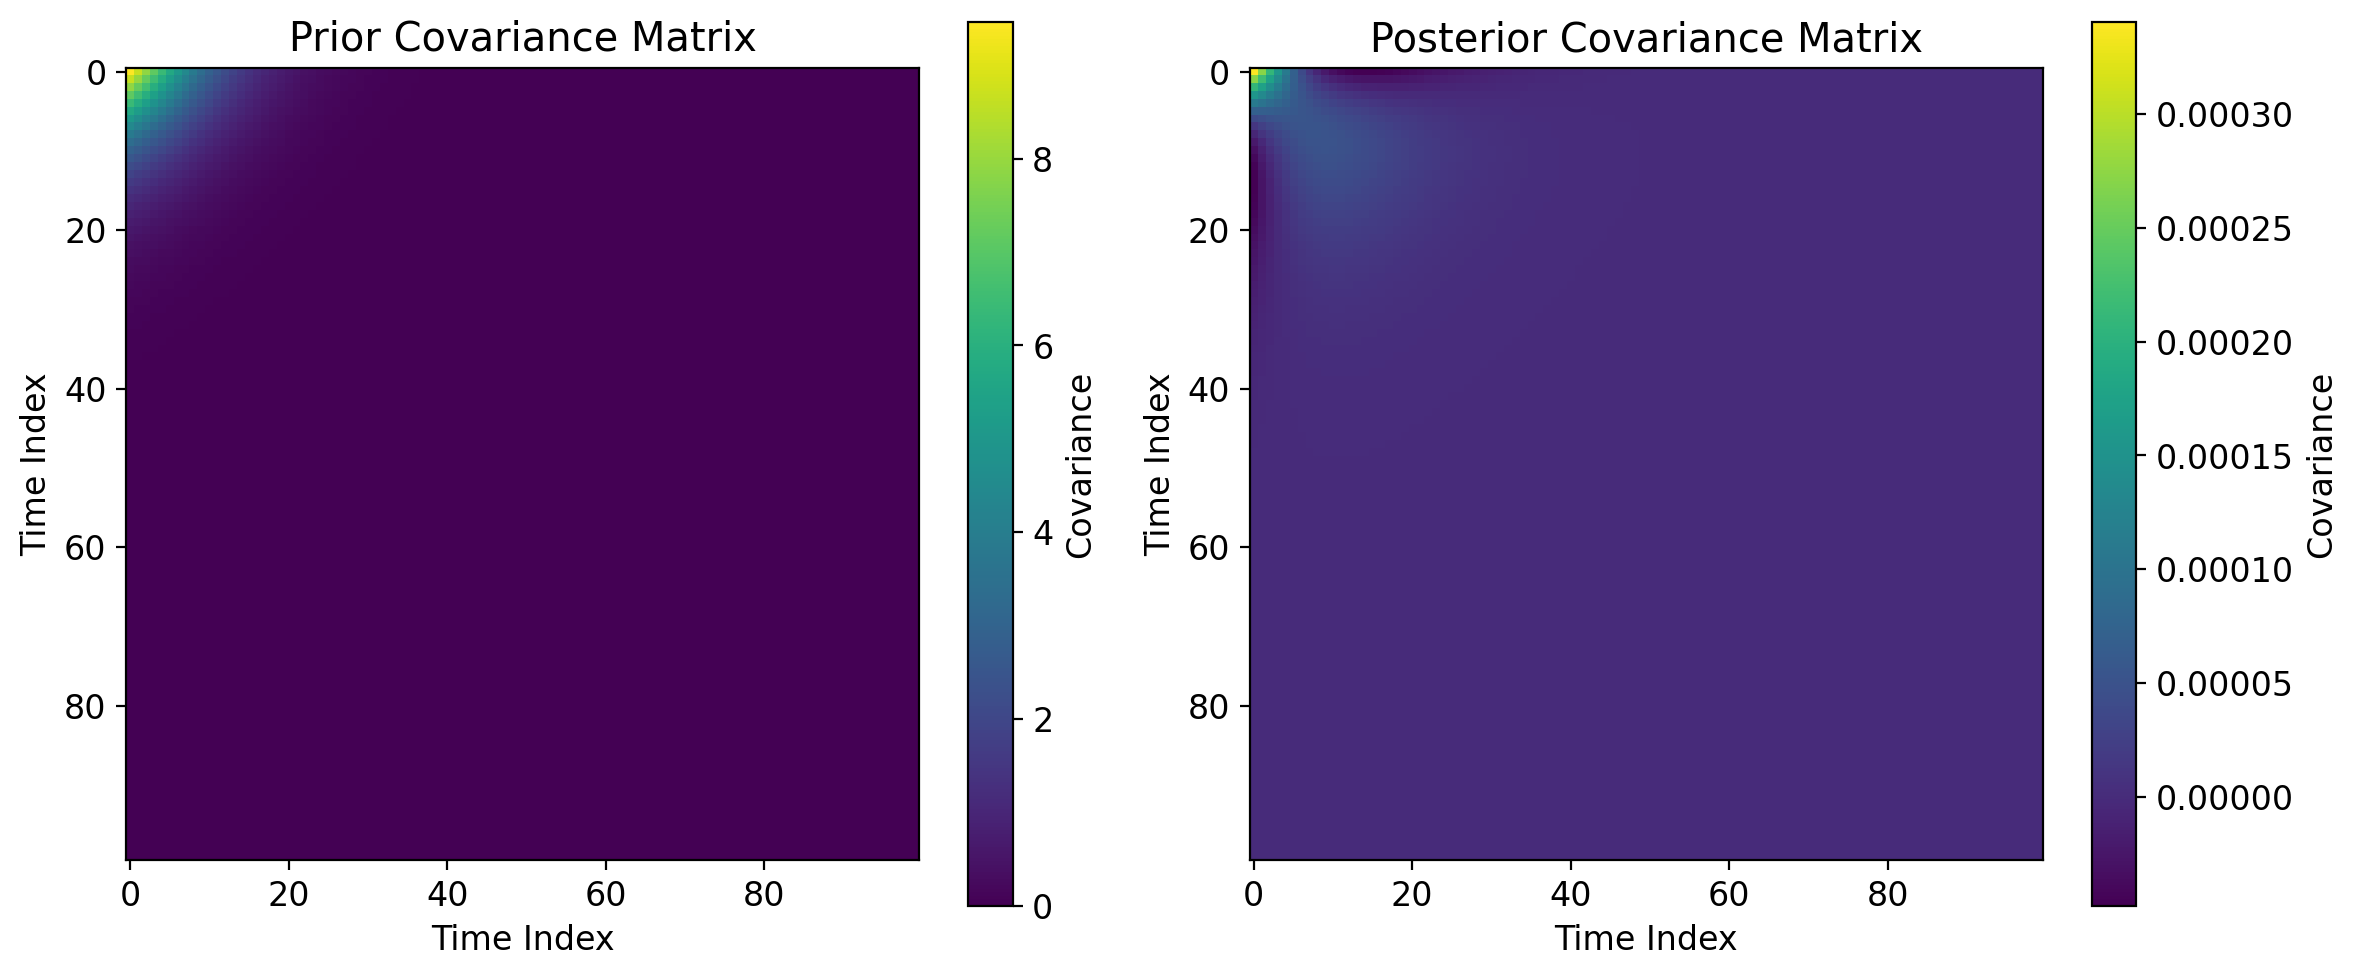

In [9]:
# Verify dtypes
assert Y.dtype == torch.float64, f"Y dtype is {Y.dtype}, expected float64"
assert time_grid.dtype == torch.float64, f"time_grid dtype is {time_grid.dtype}, expected float64"

# Test grid for visualization (0 to ~0.01 ns, 100 points, float64)
X_test = torch.linspace(0, time_sub[-1], 100, dtype=torch.float64).unsqueeze(-1)

# Prior covariance matrix
cov_prior = gp_model.f_kernel(X_test, X_test) + 1e-6 * torch.eye(len(X_test), dtype=torch.float64)
cov_prior_np = cov_prior.detach().numpy()

# Posterior covariance matrix (using Y[0])
try:
    _, cov_post = gp_model.predict(time_grid, Y[0], X_test)
    cov_post_np = cov_post.detach().numpy()
except torch.linalg.LinAlgError:
    print("Cholesky failed in predict. Using prior covariance only.")
    cov_post_np = None

# Plot covariance matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Prior covariance heatmap
im1 = ax1.imshow(cov_prior_np, cmap='viridis', interpolation='nearest')
ax1.set_title("Prior Covariance Matrix")
ax1.set_xlabel("Time Index")
ax1.set_ylabel("Time Index")
plt.colorbar(im1, ax=ax1, label="Covariance")

# Posterior covariance heatmap (if available)
if cov_post_np is not None:
    im2 = ax2.imshow(cov_post_np, cmap='viridis', interpolation='nearest')
    ax2.set_title("Posterior Covariance Matrix")
    ax2.set_xlabel("Time Index")
    ax2.set_ylabel("Time Index")
    plt.colorbar(im2, ax=ax2, label="Covariance")
else:
    ax2.set_title("Posterior Covariance (Not Available)")
    ax2.axis('off')

plt.tight_layout()
plt.show()

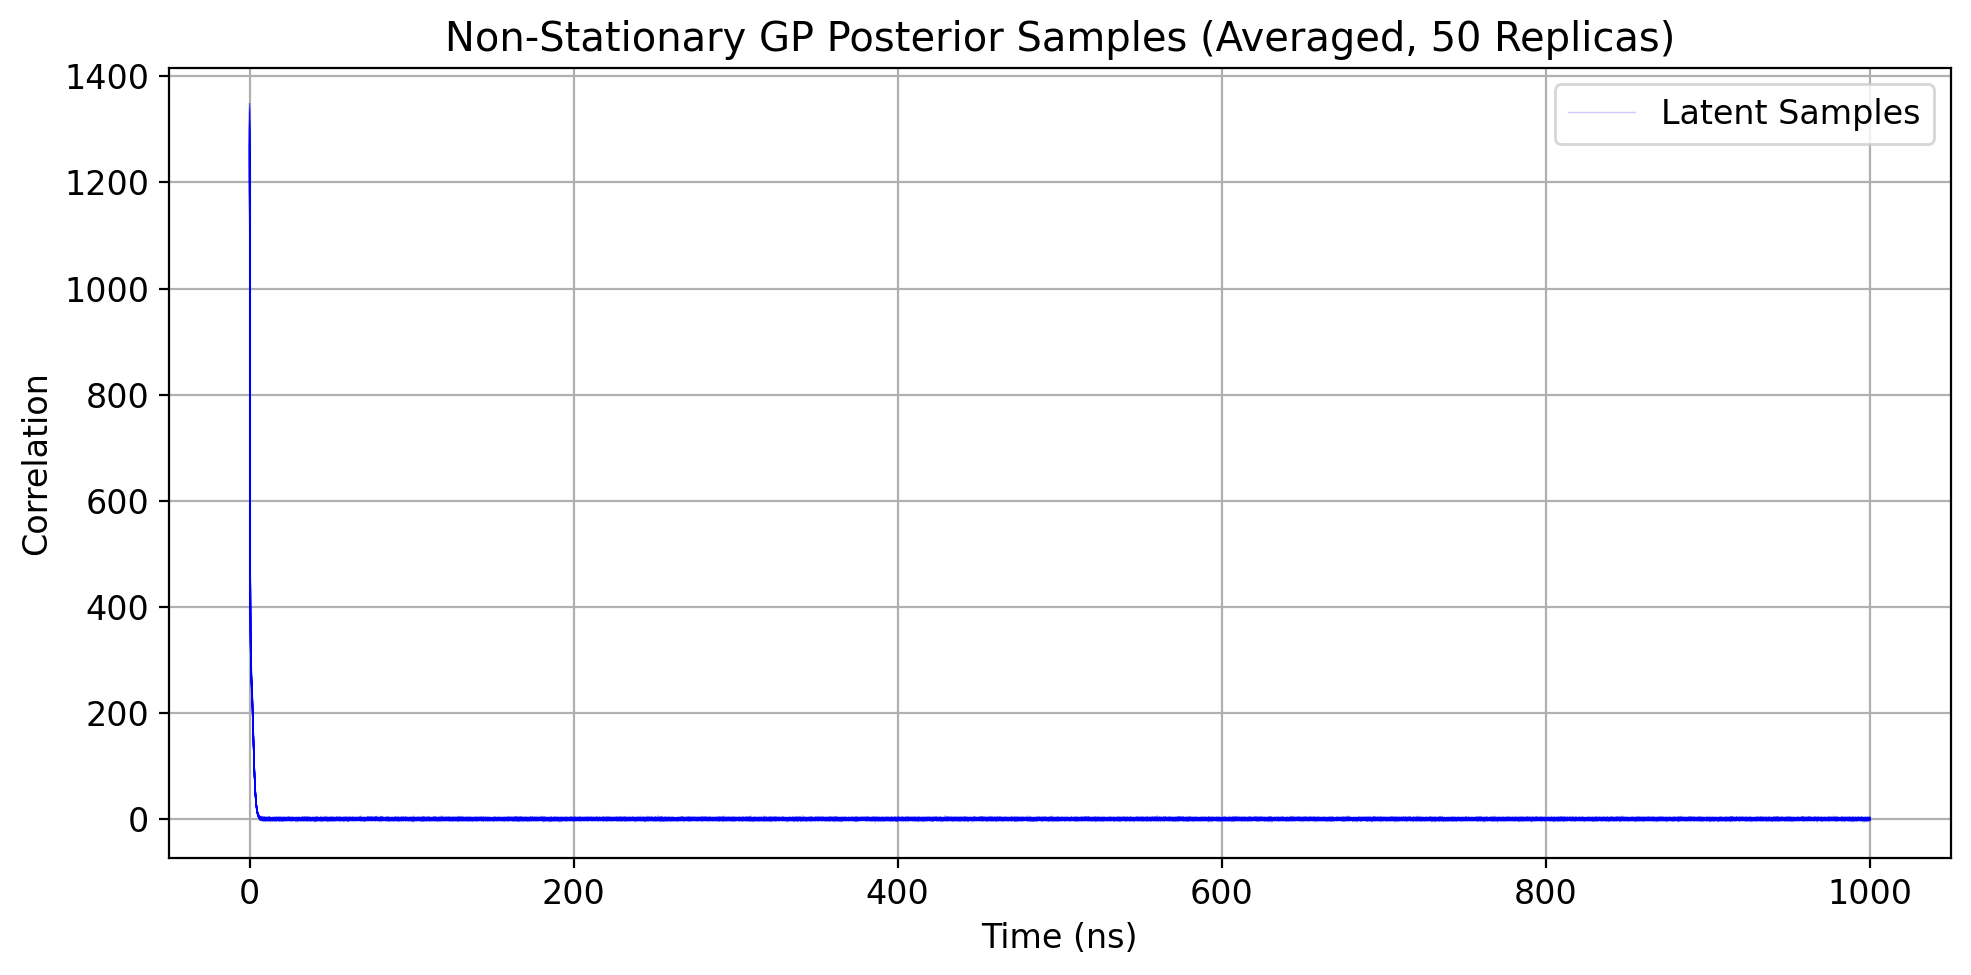

In [6]:
# Verify dtypes
assert Y.dtype == torch.float64, f"Y dtype is {Y.dtype}, expected float64"
assert time_grid.dtype == torch.float64, f"time_grid dtype is {time_grid.dtype}, expected float64"

n_points = 6001
X_test = torch.linspace(0, 1000, n_points, dtype=torch.float64).unsqueeze(-1)

# Compute posterior mean and covariance for all replicas
mu_post_replicas = []
cov_post_replicas = []
for i in range(n_replicas):
    try:
        mu_post, cov_post = gp_model.predict(time_grid, Y[i], X_test)
        mu_post_replicas.append(mu_post)
        cov_post_replicas.append(cov_post)
    except torch.linalg.LinAlgError:
        print(f"Replica {i}: Cholesky failed, skipping.")
        continue

# Average posterior mean and covariance
if mu_post_replicas:
    mu_post_avg = torch.stack(mu_post_replicas).mean(dim=0)
    cov_post_avg = torch.stack(cov_post_replicas).mean(dim=0)
    std_post = torch.sqrt(torch.diag(cov_post_avg))  # Latent standard deviation
    sigma_n = gp_model.sigma_n.item()
    std_post_with_noise = torch.sqrt(std_post**2 + sigma_n**2)  # Noisy standard deviation
else:
    raise RuntimeError("No valid posterior predictions computed.")

# Sample from averaged posterior
num_samples = 50 #number of samples from the posterior to propagate to the FT
dist = torch.distributions.MultivariateNormal(mu_post_avg, cov_post_avg + 1e-6 * torch.eye(len(X_test), dtype=torch.float64))
latent_samples = dist.sample((num_samples,))  # Shape: [num_samples, 100]
noisy_samples = latent_samples + torch.randn(num_samples, len(X_test), dtype=torch.float64) * sigma_n

# Plot samples and predictive results
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.plot(X_test.squeeze().numpy(), latent_samples[i].numpy()*scale, color='blue', alpha=0.2, lw=0.5, label="Latent Samples" if i == 0 else None)
plt.xlabel("Time (ns)")
plt.ylabel("Correlation")
plt.title("Non-Stationary GP Posterior Samples (Averaged, 50 Replicas)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/q1/9ty2s0rx2yz1wym60b_0f58c0000gn/T/ipykernel_53862/580607193.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fourier_transforms_latent[i] = torch.tensor(rfft(latent_samples[i]*scale)) * torch.tensor(dt)


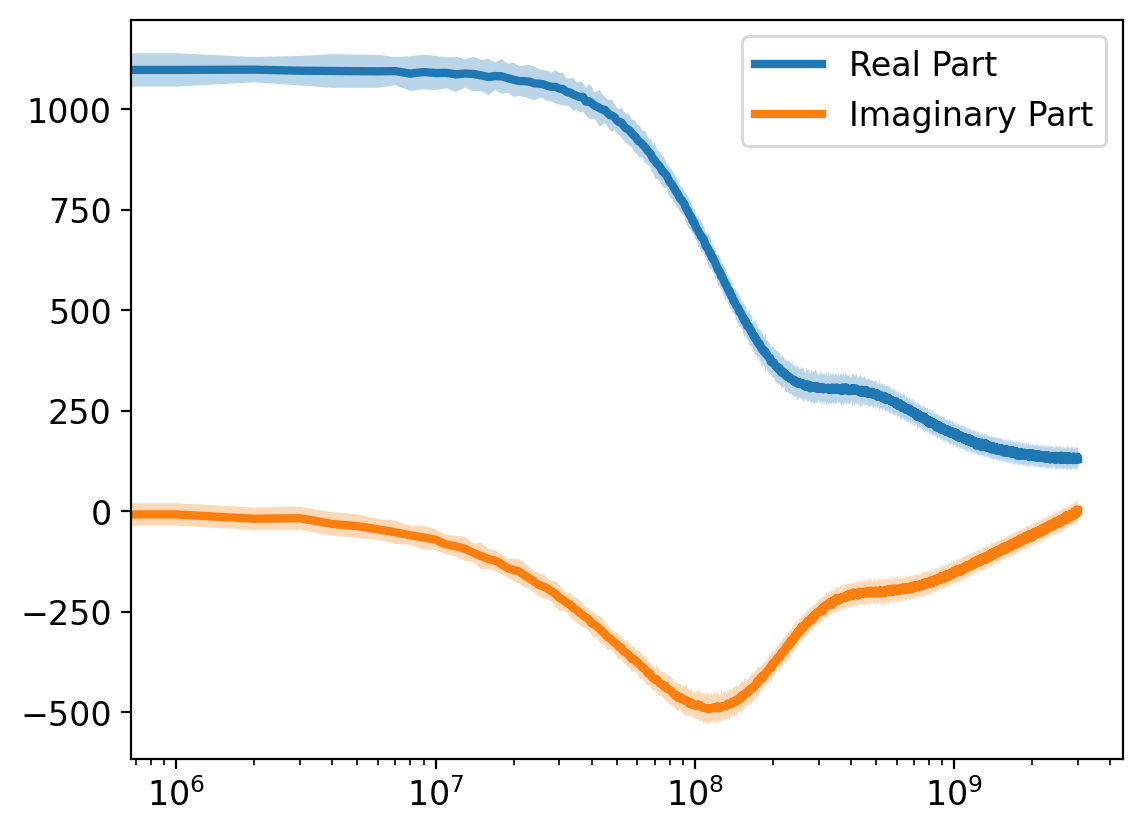

In [7]:
from scipy.fft import rfft, rfftfreq
from scipy import stats

dt = (X_test[-1] - X_test[0]) / (n_points - 1)
freq = rfftfreq(n_points, dt.item())*1e9

# Initialize arrays for FFTs
fourier_transforms_latent = torch.zeros((len(latent_samples), n_points // 2 + 1), dtype=complex)

# Compute FFTs for samples
for i in range(num_samples):
    fourier_transforms_latent[i] = torch.tensor(rfft(latent_samples[i]*scale)) * torch.tensor(dt)
    # plt.plot(freq, fourier_transforms_latent[i], color = 'gray', alpha = 0.1)
    # plt.plot(freq, fourier_transforms_latent.imag[i], color = 'gray', alpha = 0.1)
real_mean = torch.mean((fourier_transforms_latent).real, axis=0)
real_std = torch.std(fourier_transforms_latent.real, axis=0)
imag_mean = torch.mean((fourier_transforms_latent).imag, axis=0)
imag_std = torch.std(fourier_transforms_latent.imag, axis=0)
plt.xscale('log')
# plt.xlim(1e6, 1e9)
plt.plot(freq, real_mean, lw = 3, label = 'Real Part')
plt.fill_between(freq, real_mean - 2*real_std, real_mean + 2*real_std, alpha = 0.3)
plt.plot(freq, imag_mean, lw = 3, label = 'Imaginary Part')
plt.fill_between(freq, imag_mean - 2*imag_std, imag_mean + 2*imag_std, alpha = 0.3)
plt.legend()
plt.show()